# Expected Goals (xG) Model - 01
## Bayesian Single Variable Logistic Regression

In [1]:
import json
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr

import matplotlib.pyplot as plt
from plotnine import *

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

import projects.common.xg.scr.FCPython as FCPython
from projects.common.xg.scr.data_prep import make_data, stack_qcuts, calc_dist, calc_angle

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
# working with arviz structure?
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

DATA_FILEPATH = PROJECT_DIR / 'data'  / 'bigger-data' / 'football' / 'events' / 'events_England.json' 
DATA_FILEPATH

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/bigger-data/football/events/events_England.json')

# Calculate xG from Data
+ Probability that a shot becomes a goal, relative to the position of the shot on the pitch.
+ Better predictor of future performance than goals scored
+ Accounts for luck/randomness

In [3]:
df_orig = make_data(DATA_FILEPATH)
df_orig = df_orig[['X', 'Y', 'C', 'Distance', 'Distance_root', 'Angle', 'Angle_deg', 'goal']]
df_orig.head()

,X,Y,C,Distance,Distance_root,Angle,Angle_deg,goal
0,12,41,9,13.891814,3.727172,0.474451,27.184065,1
1,15,52,2,15.803560,3.975369,0.453823,26.002161,0
2,19,33,17,22.805811,4.775543,0.280597,16.077018,0
3,25,30,20,29.292704,5.412273,0.223680,12.815892,0
4,10,39,11,12.703248,3.564162,0.479051,27.447608,0


In [4]:
shots_df = df_orig.copy()
H_Shot=np.histogram2d(shots_df['X'], shots_df['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_df[shots_df['goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])
# Divide warning
prob_goal = H_Goal[0]/H_Shot[0]

/tmp/ipykernel_498452/3599928122.py:6: RuntimeWarning: invalid value encountered in true_divide


## Number of Shots

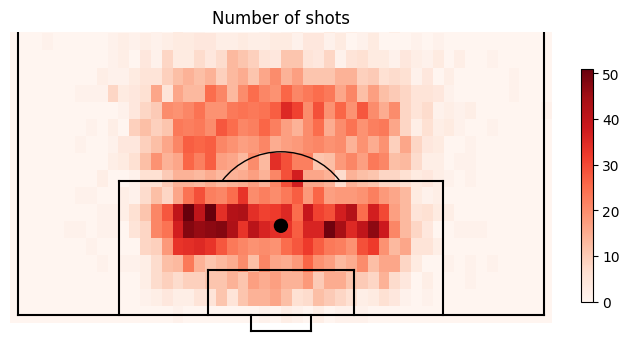

In [5]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show();

## Number of Goals

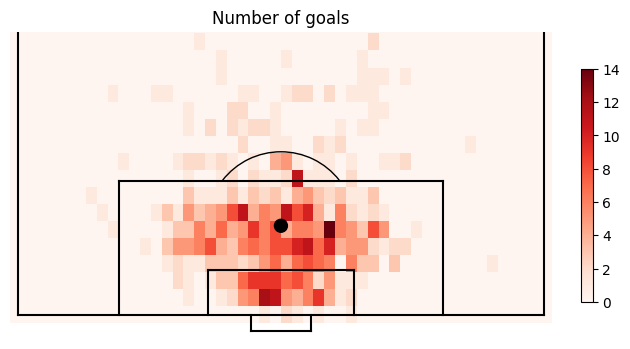

In [6]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show(); 

## Probability of a Goal

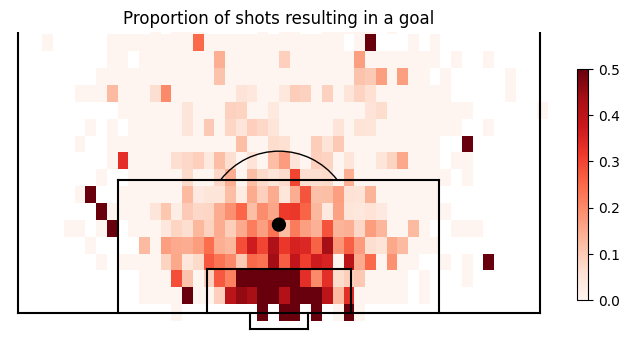

In [7]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(prob_goal, extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show();

## Probability of Goal with Minimum Number of Shots Threshold

/tmp/ipykernel_498452/2563741558.py:4: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_498452/2563741558.py:4: RuntimeWarning: invalid value encountered in true_divide


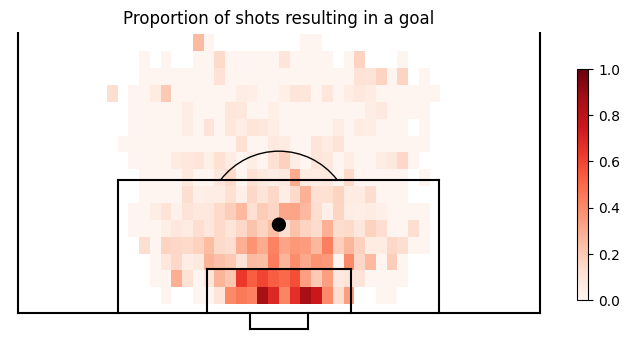

In [8]:
min_n_shots = 4
h_shots = H_Shot[0]
h_shots[h_shots < min_n_shots] = 0
prob_goal = H_Goal[0]/h_shots

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(prob_goal, extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=1.0)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Shot Geometry

In [9]:
dist_pitchmap = np.zeros((65, 65))
angle_pitchmap = np.zeros((65, 65))
combo_pitchmap = np.zeros((65, 65, 2))
for x in range(65):
    for y in range(65):
        dist_pitchmap[x,y] = calc_dist(x, y)
        angle_pitchmap[x,y] = calc_angle(x, y) 
        combo_pitchmap[x, y] = np.array([calc_dist(x,y), calc_angle(x, y)])

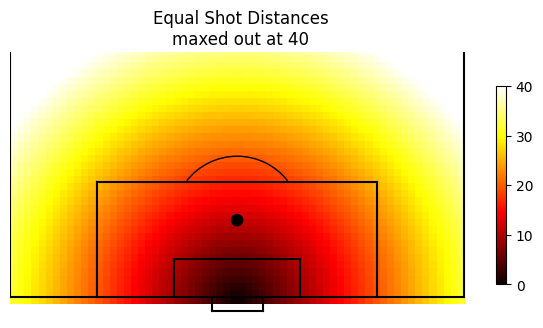

In [10]:
(fig,ax) = FCPython.createGoalMouth()
vmax = 40
pos=ax.imshow(dist_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Equal Shot Distances\nmaxed out at {vmax}')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

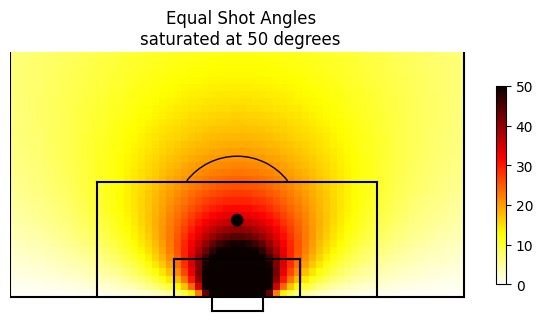

In [11]:
(fig,ax) = FCPython.createGoalMouth()
vmax = 50
pos=ax.imshow(angle_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Equal Shot Angles\nsaturated at {vmax} degrees')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Relationship Between Shot Geometry and Probability of Scoring a Goal

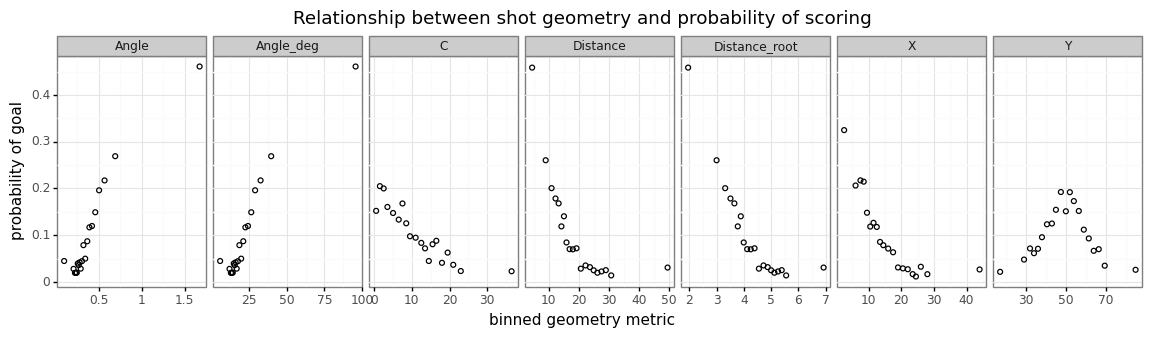

In [12]:
df_rel = df_orig.copy()

n_quantiles = 20
qcut_vars = ['X', 'Y', 'C', 'Angle', 'Distance', 'Distance_root', 'Angle_deg']

prop_on_col='goal'

df_stacked_qcuts = stack_qcuts(df_rel, qcut_vars, prop_on_col=prop_on_col, n_quantiles=n_quantiles)

p = (ggplot(df_stacked_qcuts, aes(x='midpoint', y='prob_goal')) +
     geom_point(fill='none') +
     facet_wrap('variable', nrow=1, scales='free_x') +
     theme(figure_size=(14, 3)) +
     labs(x='binned geometry metric', y='probability of goal', title='Relationship between shot geometry and probability of scoring')
    )
p.draw();

# Shot Distance Model

## Prior Predictive

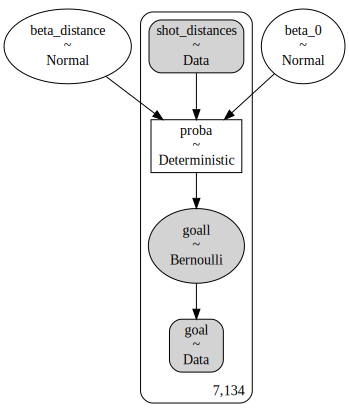

In [13]:
df_mdist = df_orig.copy()[['Distance', 'goal']]

# # Testing
# cutoff = 20
# df_mdist = df_mdist[0: cutoff]

shot_distances_obs = df_mdist['Distance'].values
goal_obs = pd.Categorical(df_mdist['goal']).codes

with pm.Model() as distance_model:
    # Priors from McElreath - Statistical rethinking 09 Modeling Events
    # https://www.youtube.com/watch?v=Zi6N3GLUJmw 49:46
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1.5)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=0.5)
    
    # Add observed data as pm.Data for more flexibility later
    # Not sure if can change between prior `sampleprior_predictive` and posterior 'sample`, but can
    # definitely update between posterior 'sample` and posterior predictive `sample_posterior_predictive`
    # Data must be same type to swap out cannot mix ints and floats
    shot_distances = pm.Data('shot_distances', shot_distances_obs)
    goal_obs = pm.Data('goal', goal_obs)

    mu = beta_0 + pm.math.dot(shot_distances, beta_distance)
    
    proba = pm.Deterministic('proba', pm.math.sigmoid(mu))
    
    goall = pm.Bernoulli('goall', p=proba, observed=goal_obs)
    
    prior_pred = pm.sample_prior_predictive()

    distance_azobj = az.from_pymc3(prior=prior_pred)

# distance_azobj.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_prior.nc')
pm.model_to_graphviz(distance_model)

In [14]:
distance_azobj

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

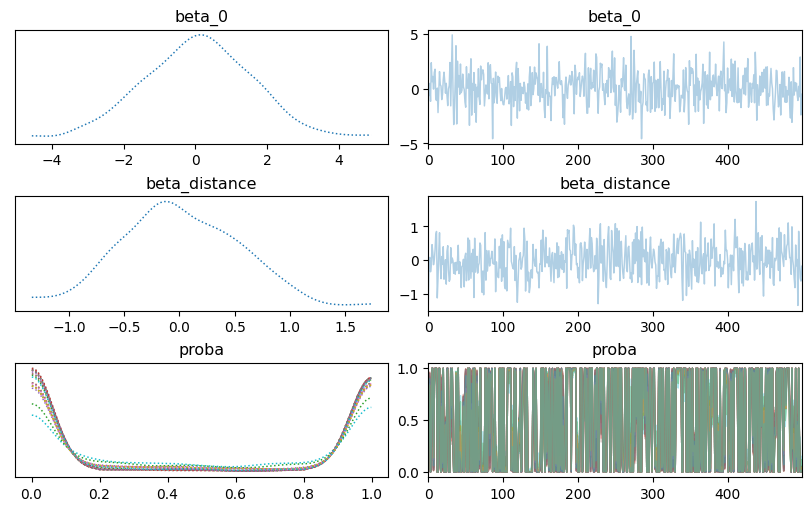

In [15]:
# Takes long time with full data
# Sample from samples or else waiting minutes
# - this is problem with prior_predictive needing to be same shape as posterior when swapping data
# Only plot sample of 20 probas - each associated with a distance
trace_plots = az.plot_trace(distance_azobj.prior, var_names=['beta_0', 'beta_distance', 'proba'], combined=True, compact=True,
                            coords={'chain': distance_azobj.prior.proba.chain.values,
                                    'draw': distance_azobj.prior.draw.values,
                                    'proba_dim_0': distance_azobj.prior.proba_dim_0.values[0:20]},
                            figsize=(8,5))

trace_plots;

In [16]:
prior_summ = az.summary(distance_azobj, kind='stats')
prior_summ['distance'] = np.hstack([shot_distances_obs, np.array([np.NaN,np.NaN])])
prior_summ = prior_summ.reset_index()
prior_summ_probas = prior_summ[prior_summ['index'].str.startswith('proba')].reset_index(drop=True)
prior_summ_probas

,index,mean,sd,hdi_3%,hdi_97%,distance
0,proba[0],0.490,0.447,0.0,1.0,13.891814
1,proba[1],0.488,0.453,0.0,1.0,15.803560
2,proba[2],0.482,0.468,0.0,1.0,22.805811
3,proba[3],0.479,0.475,0.0,1.0,29.292704
4,proba[4],0.492,0.442,0.0,1.0,12.703248
...,...,...,...,...,...,...
7129,proba[7129],0.487,0.454,0.0,1.0,16.072959
7130,proba[7130],0.479,0.476,0.0,1.0,29.579089
7131,proba[7131],0.485,0.459,0.0,1.0,18.390011
7132,proba[7132],0.489,0.450,0.0,1.0,14.818907


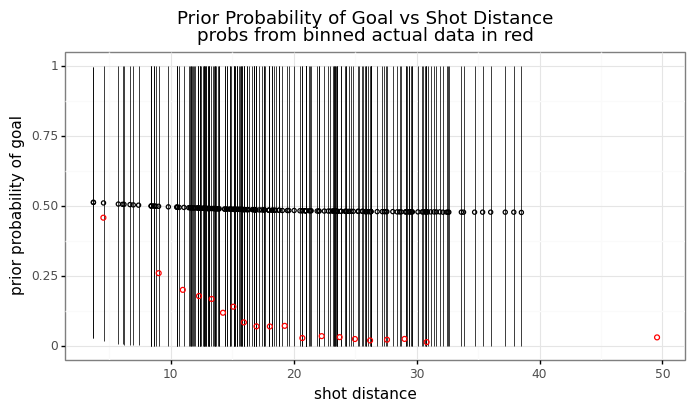

In [17]:
p = (ggplot(prior_summ_probas.sample(200), aes(x='distance')) +
     geom_pointrange(aes(y='mean', ymax='hdi_97%', ymin='hdi_3%'), fill='none', size=0.3) +
     geom_point(df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance'], aes(x='midpoint', y='prob_goal'), color='red', fill='none', alpha=1.0) +
     labs(x='shot distance',
          y='prior probability of goal',
          title=f'Prior Probability of Goal vs Shot Distance\nprobs from binned actual data in red') +
     theme(figure_size=(8, 4))
    )
p.draw();

### Is this valid?

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


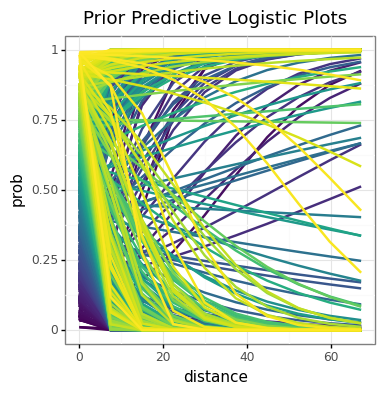

In [18]:
# draw n_prior_sample plot lines where the x axis is equi-spaced at n_distances
n_distances = 10
prior_beta_params = distance_azobj.prior[['beta_0', 'beta_distance']].to_dataframe().droplevel(0).reset_index(drop=True)
distance_samples = np.linspace(0, pd.Series(shot_distances_obs).max(), 10)

# form data
# get params as tuples - each tuple is a draw
groups = prior_beta_params.groupby(by=['beta_0', 'beta_distance']).groups
# calc probs for specified distances uding params tuple
probs = [1 / (1 + np.exp(-(group[0] + np.dot(distance_samples, group[1])))) for group in groups]
# make dfs and concat to a long shape
dfs = [pd.DataFrame({'distance': distance_samples, 'prob': prob}).assign(draw=idx) for idx, prob in enumerate(probs)]
df_curves = pd.concat(dfs, axis=0).reset_index(drop=True)

p = (ggplot(df_curves, aes(x='distance', y='prob', group='draw')) +
     geom_smooth(aes(color='draw'), span=0.01, show_legend=False) +
     labs(title="Prior Predictive Logistic Plots")+
     theme(figure_size=(4,4))
    )
p.draw();

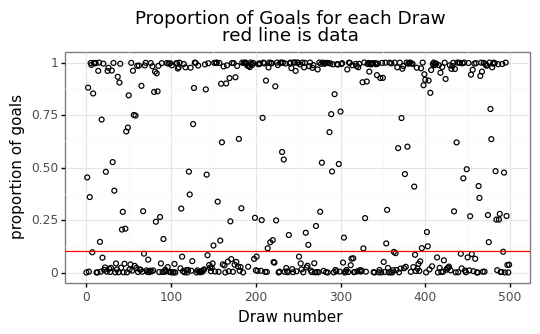

In [19]:
data_propgoal = len(df_orig[df_orig['goal']==1]) / len(df_orig)

goals = distance_azobj.prior_predictive['goall'].to_dataframe().reset_index()
goals = pd.DataFrame(goals.groupby(by=['draw'])['goall'].sum() / goals.groupby(by=['draw'])['goall'].count()).reset_index()
goals = goals.rename(columns={'goall': 'proportion_goals'}) 
p = (ggplot(goals, aes(x='draw', y='proportion_goals')) +
     geom_point(fill='none') +
     geom_hline(yintercept = data_propgoal, color='red') +
     labs(x='Draw number', y='proportion of goals', title='Proportion of Goals for each Draw\nred line is data') +
     theme(figure_size=(6,3))
    )
p.draw();

## Inference

In [20]:
n_draws = 1000
# Occasionally getting:
# - The acceptance probability does not match the target.
# - It is 0.xx but should be close to 0.8.
# - Try to increase the number of tuning steps.
# hence lifting tuning 1000 > 2000 and setting seed for reproducibility
n_tune = 2000

with distance_model:
    posterior_trace = pm.sample(n_draws, tune=n_tune, return_inferencedata=False, random_seed=1915)
    # Add posterior, log_likelihood, sample_stats, constant data to arviz diagnosis object 
    distance_azobj.extend(az.from_pymc3(trace=posterior_trace))
# distance_azobj.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_posterior.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_distance, beta_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8809692482696273, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [21]:
distance_azobj

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats
	> constant_data

In [22]:
az.rhat(distance_azobj, var_names=['beta_0', 'beta_distance', 'proba']).to_dataframe().mean(axis=0)

beta_0           1.010170
beta_distance    1.008562
proba            1.002295
dtype: float64

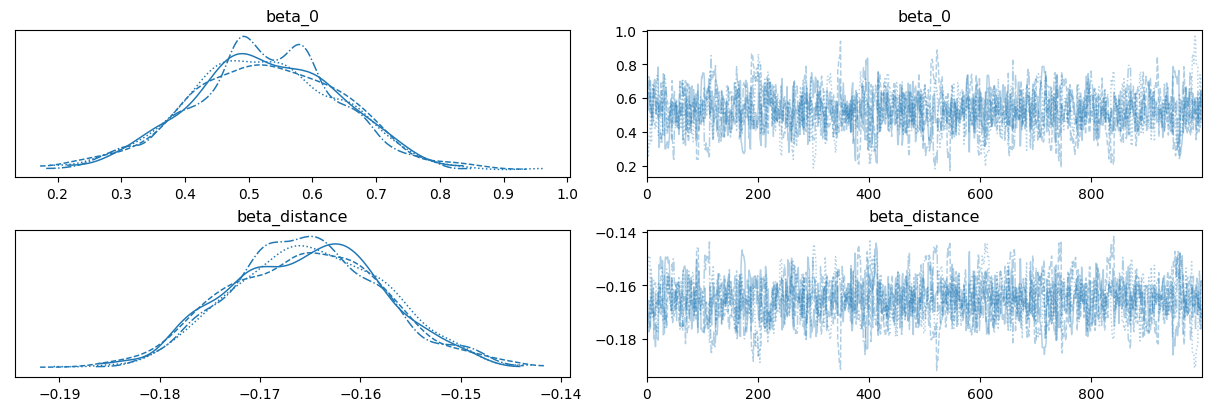

In [23]:
distance_azobj.posterior.dims
az.plot_trace(distance_azobj, var_names=['beta_0', 'beta_distance']);

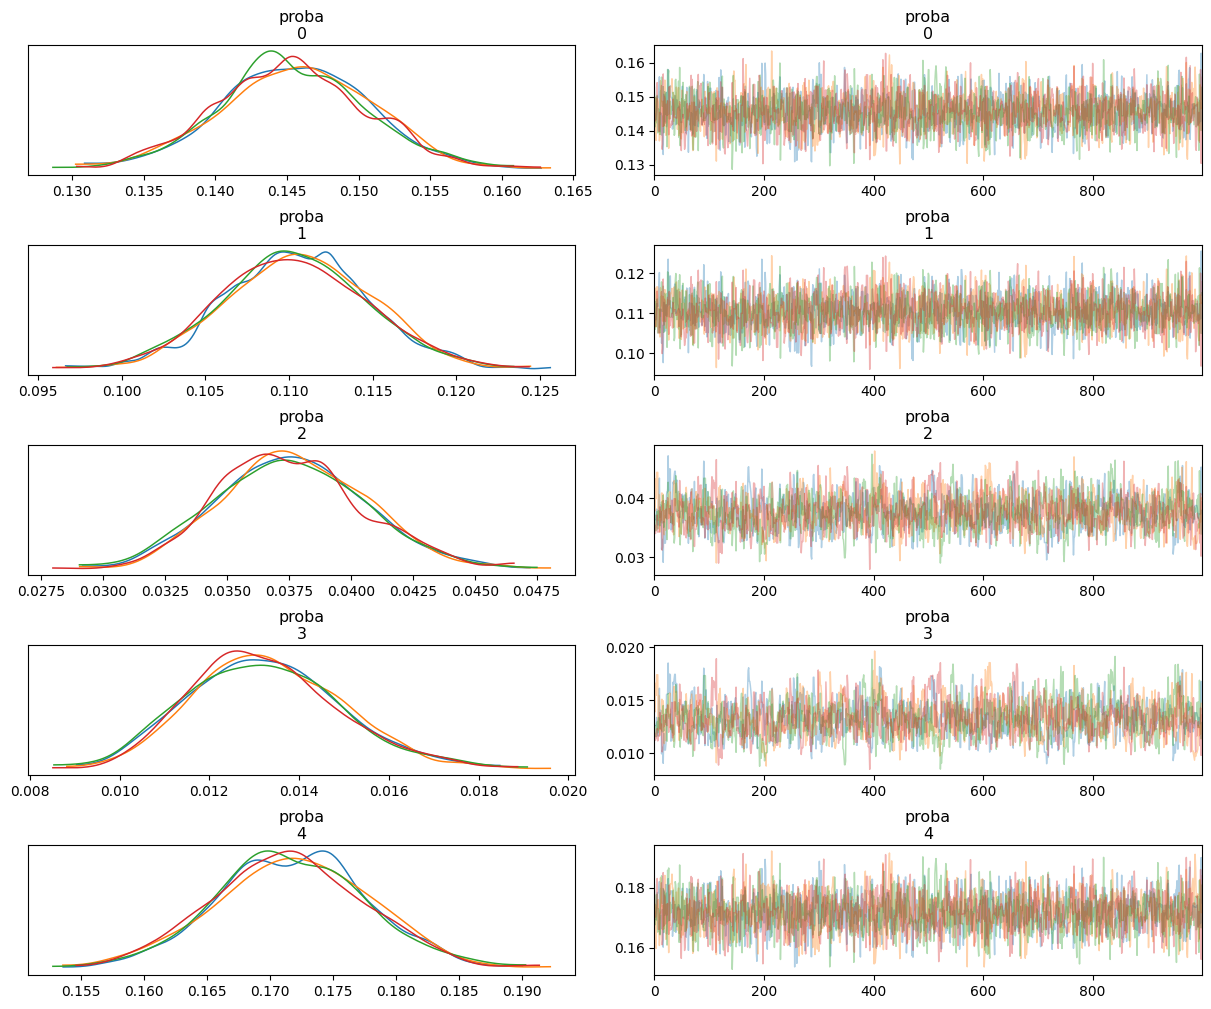

In [24]:
trace_plots = az.plot_trace(distance_azobj.posterior, var_names=['proba'], combined=False, compact=False,
                            coords={'chain': distance_azobj.posterior.proba.chain.values,
                                    'draw': distance_azobj.posterior.proba.draw.values,
                                    'proba_dim_0': distance_azobj.posterior.proba.proba_dim_0.values[0:5]})
trace_plots;

In [25]:
summ = az.summary(distance_azobj, kind='stats')
summ['distance'] = np.hstack([np.array([np.NaN,np.NaN]), shot_distances_obs])
summ.head(5)

,mean,sd,hdi_3%,hdi_97%,distance
beta_0,0.526,0.118,0.302,0.741,NaN
beta_distance,-0.165,0.008,-0.179,-0.150,NaN
proba[0],0.146,0.005,0.136,0.155,13.891814
proba[1],0.110,0.004,0.102,0.118,15.803560
proba[2],0.038,0.003,0.032,0.043,22.805811


In [26]:
df_stacked_qcuts.head(3)

,index,bin,goal,prob_goal,variable,midpoint
0,0,"(-0.001, 5.0]",1,0.324675,X,2.4995
1,1,"(5.0, 7.0]",1,0.206266,X,6.0000
2,2,"(7.0, 8.0]",1,0.217228,X,7.5000


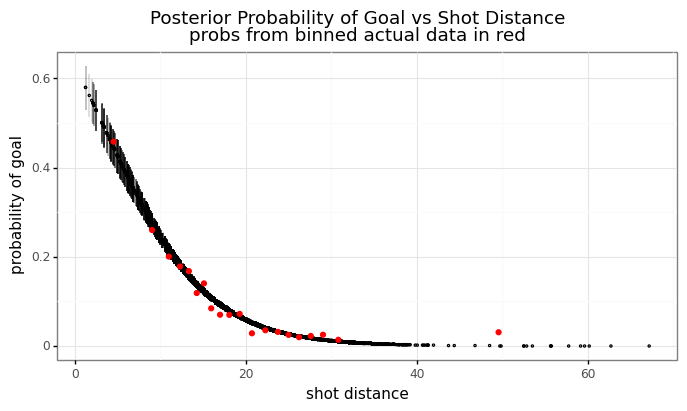

In [27]:
post_probs = summ[2:]
p = (ggplot(post_probs, aes(x='distance')) +
     geom_pointrange(aes(y='mean', ymax='hdi_97%', ymin='hdi_3%'), fill='none', size=0.1) +
     geom_point(df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance'], aes(x='midpoint', y='prob_goal'), color='red') +
     labs(x='shot distance',
          y='probability of goal',
          title=f'Posterior Probability of Goal vs Shot Distance\nprobs from binned actual data in red') +
     theme(figure_size=(8, 4))
    )
p.draw();

## Predictions
### Posterior Predictive

In [28]:
with distance_model:
    post_pred = pm.sample_posterior_predictive(posterior_trace)
    distance_azobj.extend(az.from_pymc3(posterior_predictive=post_pred))
# distance_azobj.to_netcdf(DATA_FILEPATH.parent / 'azobj_posterior_predictive.nc')

In [29]:
distance_azobj

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats
	> constant_data
	> posterior_predictive

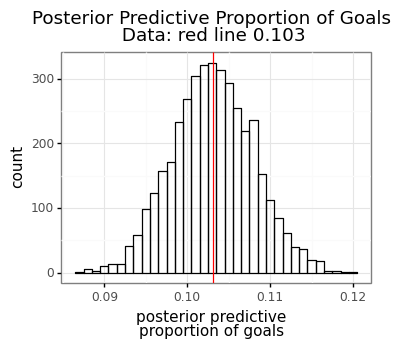

In [30]:
# a bit big -  4 chains x 4000 draws x 7134 (observed) distances.
post_pred_goals = distance_azobj.posterior_predictive.goall.to_dataframe().droplevel(0)
post_pred_goals_sum = post_pred_goals.groupby(level=0).sum()
post_pred_goals_count = post_pred_goals.groupby(level=0).count()
post_pred_goals_prop = (post_pred_goals_sum / post_pred_goals_count).rename(columns={'goall': 'prob_goal'})

p = (ggplot(post_pred_goals_prop, aes('prob_goal')) +
     geom_histogram(fill='none', color='black', binwidth=0.0010) +
     geom_vline(xintercept=data_propgoal, color='red') +
     xlab("count") +
     xlab("posterior predictive\nproportion of goals") +
     labs(title=f"Posterior Predictive Proportion of Goals\n Data: red line {data_propgoal:.3f}") +
     theme(figure_size=(4, 3))
    )
p.draw();

In [31]:
az.loo(distance_azobj)

Computed from 4000 by 7134 log-likelihood matrix

         Estimate       SE
elpd_loo -2013.08    52.64
p_loo        2.58        -

In [32]:
az.waic(distance_azobj)

Computed from 4000 by 7134 log-likelihood matrix

          Estimate       SE
elpd_waic -2013.08    52.64
p_waic        2.58        -

### Apply Model to Unseen data - Distance range
+ Need to get probabilities for an equi-spaced array of distances OR in this case use the quantile cuts, so we can produce a calibration plot of the model predicted probs. vs, the probs calculated from the data
+ Running posterior_predictive_sample will only return goal data, but we are really interested in the underlying probability data
+ Therefore, swap the distances data for the new distances and run sample to get the posterior probabilities.
+ We will use the posterior beta distributions from the trained model to create the new probabilities at the new distances

In [33]:
n_draws = 1000
shot_distances_range = df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance'].reset_index(drop=True)['midpoint'].values
# Alternate equi-spaced distances - but not set up for reliability plot
# max_distance = int(df_mdist['Distance'].max()) + 5
# shot_distances_range = np.arange(0, max_distance, 1).astype(float)
# n_distances = shot_distances_range.shape[0]
n_distances = shot_distances_range.shape[0]

with distance_model:    
    # Set the new distances as shot distances
    shot_distances = pm.set_data({'shot_distances': shot_distances_range})
    post_pred = pm.sample_posterior_predictive(posterior_trace,
                                               # var_namesIterable[str]
                                               # Names of variables for which to compute the posterior predictive samples.
                                                var_names=['goall', 'proba', 'beta_0', 'beta_distance'])
    # Create a new object for the oos data
    oos_distance_azobj = az.from_pymc3(posterior_predictive=post_pred)

In [34]:
oos_distance_azobj

Inference data with groups:
	> posterior_predictive
	> observed_data

In [35]:
oos_summ = az.summary(oos_distance_azobj.posterior_predictive, kind='stats')
oos_probs = oos_summ.loc[[l for l in oos_summ.index if 'proba' in l]]
oos_probs['distance'] = shot_distances_range
oos_probs['data_mean_prob'] = df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance']['prob_goal'].values
oos_probs.head()

,mean,sd,hdi_3%,hdi_97%,distance,data_mean_prob
proba[0],0.445,0.021,0.403,0.482,4.5150,0.458333
proba[1],0.276,0.011,0.255,0.297,9.0160,0.260274
proba[2],0.216,0.008,0.200,0.231,10.9765,0.200557
proba[3],0.182,0.007,0.169,0.194,12.2910,0.178470
proba[4],0.158,0.006,0.148,0.169,13.3270,0.168044


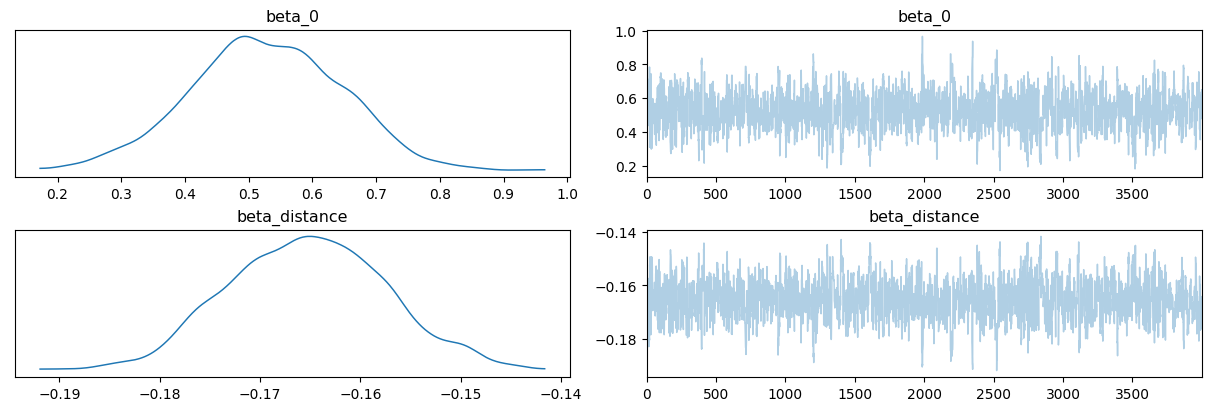

In [36]:
az.plot_trace(oos_distance_azobj.posterior_predictive, var_names=['beta_0', 'beta_distance']);

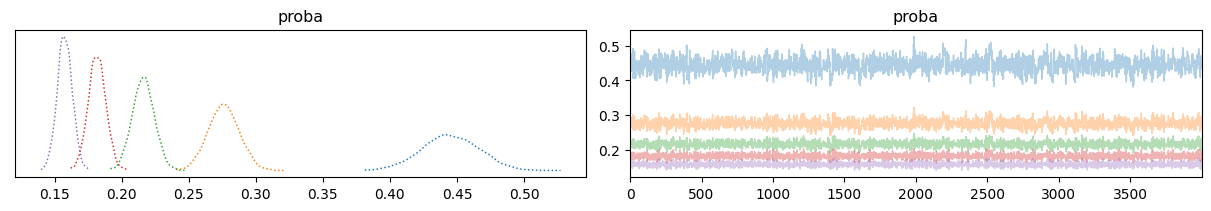

In [37]:
trace_plots = az.plot_trace(oos_distance_azobj.posterior_predictive, var_names=['proba'], combined=True, compact=True,
                            coords={'chain': oos_distance_azobj.posterior_predictive.proba.chain.values,
                                    'draw': oos_distance_azobj.posterior_predictive.proba.draw.values,
                                    'proba_dim_0': oos_distance_azobj.posterior_predictive.proba.proba_dim_0.values[0:5]})
trace_plots;

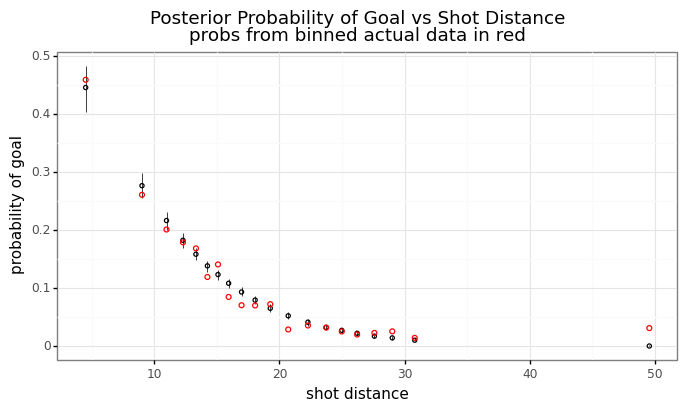

In [38]:
p = (ggplot(oos_probs, aes(x='distance')) +
     geom_pointrange(aes(y='mean', ymax='hdi_97%', ymin='hdi_3%'), fill='none', size=0.3) +
     geom_point(df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance'], aes(x='midpoint', y='prob_goal'), color='red', fill='none', alpha=1.0) +
     labs(x='shot distance',
          y='probability of goal',
          title=f'Posterior Probability of Goal vs Shot Distance\nprobs from binned actual data in red') +
     theme(figure_size=(8, 4))
    )
p.draw();

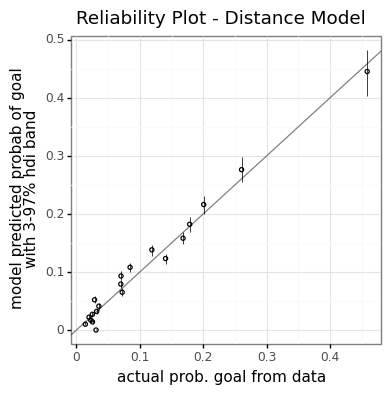

In [39]:
p = (ggplot(oos_probs, aes(x='data_mean_prob')) +
     geom_pointrange(aes(y='mean', ymax='hdi_97%', ymin='hdi_3%'), fill='none', size=0.3) +
     geom_abline(intercept=0, slope=1, alpha=0.5) +
     labs(x='actual prob. goal from data',
          y='model predicted probab of goal\nwith 3-97% hdi band',
          title=f'Reliability Plot - Distance Model') +
     theme(figure_size=(4, 4))
    )
p.draw();

In [40]:
# Placeholder - Calculate ECE for model comparison

### Apply Model to Unseen data - Pitch map

In [41]:
pitch_shot_distances = dist_pitchmap.flatten()

with distance_model:    
    # Set the pitch distances as the new shot distances data
    shot_distances = pm.set_data({'shot_distances': pitch_shot_distances})
    post_pred = pm.sample_posterior_predictive(posterior_trace,
                                                var_names=['goall', 'proba', 'beta_0', 'beta_distance'])
    # Create a new object for the oos data
    pitch_distance_azobj = az.from_pymc3(posterior_predictive=post_pred)

### Check Model Predictions against Data

In [42]:
oos_summ = az.summary(pitch_distance_azobj.posterior_predictive, kind='stats')
pitch_probs = oos_summ.loc[[l for l in oos_summ.index if 'proba' in l]]
pitch_probs['distance'] = pitch_shot_distances
pitch_probs['range'] = pitch_probs['hdi_97%'] - pitch_probs['hdi_3%']
pitch_probs.head()

,mean,sd,hdi_3%,hdi_97%,distance,range
proba[0],0.008,0.001,0.006,0.010,32.5,0.004
proba[1],0.009,0.001,0.007,0.012,31.5,0.005
proba[2],0.011,0.001,0.008,0.014,30.5,0.006
proba[3],0.013,0.002,0.010,0.016,29.5,0.006
proba[4],0.015,0.002,0.012,0.019,28.5,0.007


In [43]:
mean_probs_pitchmap = pitch_probs['mean'].values.reshape((65, 65))
lo_probs_pitchmap = pitch_probs['hdi_3%'].values.reshape((65, 65))
hi_probs_pitchmap = pitch_probs['hdi_97%'].values.reshape((65, 65))
probs_range_pitchmap = pitch_probs['range'].values.reshape((65, 65))

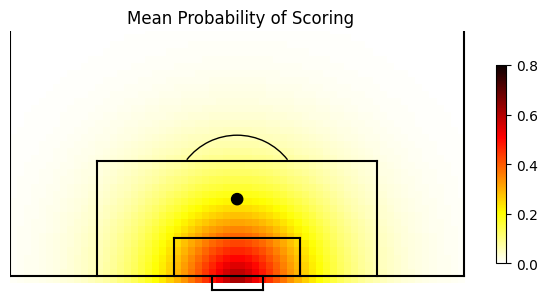

In [44]:
(fig,ax) = FCPython.createGoalMouth()
vmax = .8
pos=ax.imshow(mean_probs_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Mean Probability of Scoring')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

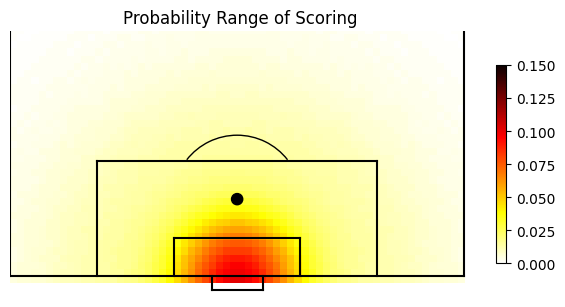

In [45]:
(fig,ax) = FCPython.createGoalMouth()
vmax1 = .15
pos=ax.imshow(probs_range_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax1)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Probability Range of Scoring')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

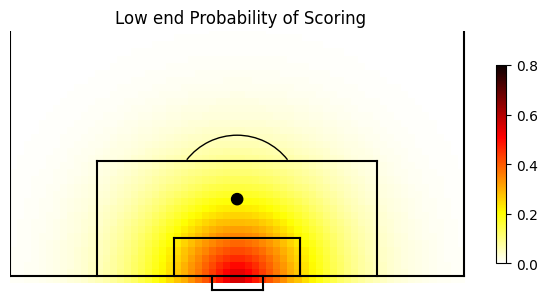

In [46]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(lo_probs_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Low end Probability of Scoring')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

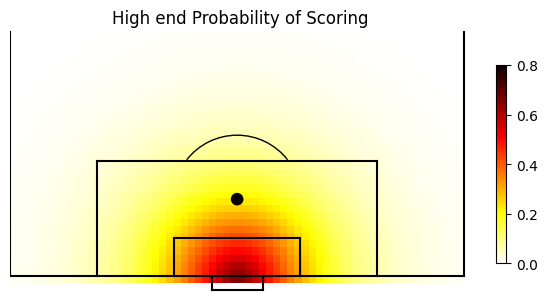

In [47]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(hi_probs_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'High end Probability of Scoring')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

/tmp/ipykernel_498452/4226567880.py:4: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_498452/4226567880.py:4: RuntimeWarning: invalid value encountered in true_divide


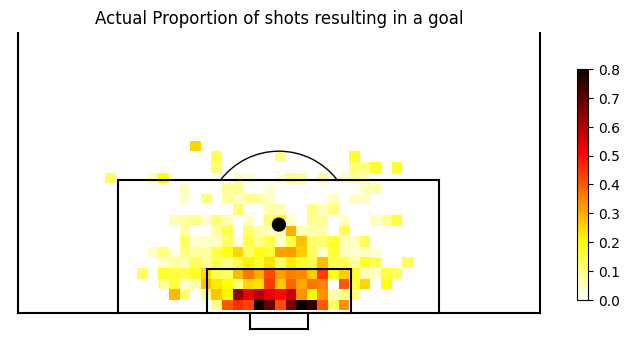

In [48]:
min_n_shots = 4
h_shots = H_Shot[0]
h_shots[h_shots < min_n_shots] = 0
prob_goal = H_Goal[0]/h_shots

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(prob_goal, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Actual Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

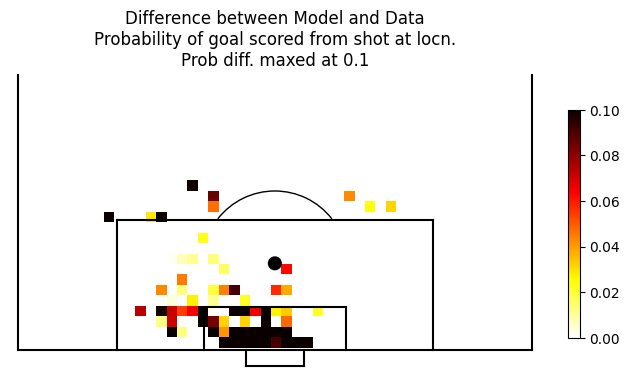

In [49]:
cal_probs = prob_goal - mean_probs_pitchmap[0:50, 0:50]
(fig,ax) = FCPython.createGoalMouth()
vmax=0.1
pos=ax.imshow(cal_probs, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Difference between Model and Data\nProbability of goal scored from shot at locn.\nProb diff. maxed at 0.1')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show() 

# Alternative Models
+ Perceived area model - game graphic style - [Perspective projection](https://www.youtube.com/watch?v=EqNcqBdrNyI&list=PLdw9iy95A5dh9tr3ZEiPICRYu8geqi9N9&index=58&t=1014s)
    + Could incorporate positions of players between shooter and goal to modify the perceived area
+ Flight Time Model - the longer the ball is flying, the more time the goalie has to react. Could incorporate position of goalie at shot instant relative to xy location of ball when it crosses the line. Is save possible within flight time?
    + [Time of flight relationship to distance](https://www.studocu.com/en-us/messages/question/2801482/in-projectile-motion-is-there-a-direct-relationship-between-time-in-the-air-and-the-range)

# References

+ [Kaggle Data](https://www.kaggle.com/datasets/aleespinosa/soccer-match-event-dataset)
+ **[Figshare data - Version 2 used in this Notebook to match Friends of Tracking Code](https://figshare.com/collections/Soccer_match_event_dataset/4415000/5)**
+ [Nature Paper](https://www.nature.com/articles/s41597-019-0247-7)
+ [Wyscout Event tags](https://support.wyscout.com/matches-wyid-events#10-available-tag-ids)
+ [Github - Exploring spatio-temporal soccer events using public event data](https://github.com/Friends-of-Tracking-Data-FoTD/mapping-match-events-in-Python)
+ [McElreath - Statistical rethinking 09 Modeling Events 49:46](https://www.youtube.com/watch?v=Zi6N3GLUJmw)
+ [Models based on Bayesian Modeling and Computation Book - Chapter 3 Code Listing 3.1](https://bayesiancomputationbook.com/markdown/chp_03.html#classifying-penguins)
+ Friends of Tracking Video Series
    + **[How to Build an Expected Goals Model 1: Model and data](https://www.youtube.com/watch?v=bpjLyFyLlXs)**
    + **[How to Build An Expected Goals Model 2: Statistical fitting](https://www.youtube.com/watch?v=wHOgINJ5g54)**
    + [How to Build An Expected Goals Model 2: Statistical fitting](https://www.youtube.com/watch?v=wHOgINJ5g54)
    + [The Ultimate Guide to Expected Goals](https://www.youtube.com/watch?v=310_eW0hUqQ)
    + [Associated Code - 3xGModel & 5xGModelFit](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython)
    + [Geometry Calculations - The Geometry of Shooting](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760)